In [9]:
import os
import torch
import tarfile
import zipfile
import hashlib
import requests
import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt
DATA_HUB = dict() # 存储文件路径及文件对应的SHA-1哈希值
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'
DATA_HUB['kaggle_house_train'] = (DATA_URL + 'kaggle_house_pred_train.csv',
                                '585e9cc93e70b39160e7921475f9bcd7d31219ce')
DATA_HUB['kaggle_house_test'] = (DATA_URL + 'kaggle_house_pred_test.csv',
                                'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')
def download(name, cache_dir=os.path.join('data','house pred')):
    """下载一个DATA_HUB中的文件并返回本地文件名"""
    assert name in DATA_HUB, f"{name} 不存在于 {DATA_HUB}"
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1() # 计算给定字符串的SHA-1哈希值
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576) # 参数:读取1MB内容
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash: # 检查哈希值判定文件是否已经存在
            return fname # 命中缓存
    print(f'正在从{url}下载{fname}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname
def download_extract(name, folder=None):
    """下载并解压zip/tar文件"""
    fname = download(name)
    base_dir = os.path.dirname(fname) # dirname(name)查询name文件所在的文件夹的路径
    data_dir, ext = os.path.splitext(fname) # splitext 将文件名与文件后缀(如.zip)分割为具有两元素的元组
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, '只有zip/tar文件可以被解压缩'
    fp.extractall(base_dir) # 将压缩的文件解压到base_dir路径下
    return os.path.join(base_dir, folder) if folder else data_dir
def download_all():
    """下载DATA_HUB中的所有文件"""
    for name in DATA_HUB:
        download(name)

"""
Kaggle房价数据集:
训练数据集包括1460个样本,每个样本80个特征和1个标签
测试数据集包含1459个样本,每个样本80个特征。
数据集的第一列是序号,需要切片去掉
"""
train_data = pd.read_csv(download('kaggle_house_train'))
test_data = pd.read_csv(download('kaggle_house_test'))

正在从http://d2l-data.s3-accelerate.amazonaws.com/kaggle_house_pred_train.csv下载data/house pred/kaggle_house_pred_train.csv...
正在从http://d2l-data.s3-accelerate.amazonaws.com/kaggle_house_pred_test.csv下载data/house pred/kaggle_house_pred_test.csv...


In [10]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))
# 处理数据之前 需要将所有缺失的值替换为相应特征的平均值,并将所有特征缩放到同一尺度上
# 特征缩放方法: x[i] = (x[i] - mean(x))/std(x)  mean是均值 std是标准差 此方法将特征x的均值置为0,标准差置为1
# 若无法获得测试数据,则可根据训练数据计算均值和标准差
numeric_features_idx = all_features.dtypes[all_features.dtypes != 'object'].index # 找到所有值为数字的列的名称索引
all_features[numeric_features_idx] = all_features[numeric_features_idx].apply(lambda x: (x - x.mean()) / (x.std())) # apply()将一个函数应用于某一轴
# 在标准化数据之后,所有均值消失,因此可以将缺失值设置为0
all_features[numeric_features_idx] = all_features[numeric_features_idx].fillna(0) # fillna()函数将缺失值置为指定值
# get_dummies 将非数字列创建为一个独热标签, dummy_na=True表示为NA的列创建一个指示列,指示哪些地方为NA
all_features = pd.get_dummies(all_features, dummy_na=True,dtype=int)
n_train = train_data.shape[0]
# 用.values从pandas.DataFrame中提取numpy格式
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
train_labels = torch.tensor(train_data.SalePrice.values.reshape(-1,1), dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)

In [11]:
loss_function = nn.MSELoss() # 均方误差损失函数
in_features = train_features.shape[1]

net = nn.Sequential(
    nn.Linear(in_features, 1))

def log_RMSE(net, features, labels):
    # 为了取对数时进一步稳定该值, 将小于1的值设为1
    preds = torch.clamp(net(features), min=1, max=float('inf')) # clamp():将tensor中的值限制在[min,max]范围内,在范围外的被取为最小/最大值
    RMSELoss = torch.sqrt(loss_function(torch.log(preds), torch.log(labels)))# 均方根对数误差 = sqrt( (1/n) * Sigma(1,n){log y[i]-log y_hat[i]} )
    return RMSELoss.item() # .item() 取出tensor中的值 比如 tensor(1.4142) -> 1.4142

In [12]:
# 借助Adam优化器优化
from torch.utils.data import TensorDataset, DataLoader
def train(net, train_features, train_labels, test_features, test_labels, 
          num_epoches, batch_size ,learning_rate, weight_decay):
      train_res, test_res =[], []  # 用于记录每次训练的损失
      train_dataset = TensorDataset(train_features,train_labels) # 用Pytorch的Dataset类构造自己的Dataset
      train_iter = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
      optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=weight_decay)
      for epoch in range(num_epoches):
            for X, y in train_iter:
                  optimizer.zero_grad()
                  loss = loss_function(net(X), y)
                  loss.backward()
                  optimizer.step()
            train_res.append(log_RMSE(net, train_features, train_labels))
            if test_res is not None:
                  test_res.append(log_RMSE(net, test_features, test_labels))
      return train_res, test_res

In [13]:
def get_K_fold_data(K, i, X, y) -> torch.Tensor: # 返回第i折的数据 即选择第i个切片作为验证数据,其余部分作为训练数据
    assert K > 1, "K必须大于1"
    folder_size = X.shape[0] // K
    X_train, y_train = None, None
    for j in range(K):
        idx = slice(j*folder_size, (j+1)*folder_size) # 创建一个slice类 slice类可作为列表的索引使用 slice(start, end, step) -> list[start : end : step]
        X_part, y_part = X[idx, : ], y[idx] # 选择第j个切片
        if j == i: # j=i 时 为不选择的第i个切片,即验证集
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else: # j != i 时 将j部分的切片连接到训练集上
            X_train = torch.cat([X_train, X_part], dim=0)
            y_train = torch.cat([y_train, y_part], dim=0)
    return X_train, y_train, X_valid, y_valid
def K_fold(K, X_train, y_train, num_epochs, batch_size,learning_rate, weight_decay) -> float :
    # 返回在K折交叉验证中训练K次后 训练和验证误差的平均值
    train_loss_sum, valid_loss_sum = 0, 0
    for i in range(K):
        data = get_K_fold_data(K, i, X_train, y_train)
        train_res, valid_res = train(net, *data, num_epochs, batch_size, learning_rate, weight_decay)
        train_loss_sum += train_res[-1]
        valid_loss_sum += valid_res[-1]
        if i == 0:
            plt.plot(list(range(1, num_epochs+1)), train_res, label = "train_loss")
            plt.plot(list(range(1, num_epochs+1)), valid_res, label = "valid_loss")
            plt.xlabel('num_epoch'), plt.ylabel('loss')
            plt.title('Train Result')
            plt.legend()
        print(f'折{i + 1},训练集log rmse={float(train_res[-1]):f}, '
            f'验证集log rmse={float(valid_res[-1]):f}')
    return train_loss_sum / K, valid_loss_sum / K

折1,训练集log rmse=1.446663, 验证集log rmse=1.457690
折2,训练集log rmse=0.776103, 验证集log rmse=0.785165
折3,训练集log rmse=0.411757, 验证集log rmse=0.428054
折4,训练集log rmse=0.220568, 验证集log rmse=0.244923
折5,训练集log rmse=0.179953, 验证集log rmse=0.160052
折6,训练集log rmse=0.163220, 验证集log rmse=0.173201
折7,训练集log rmse=0.158617, 验证集log rmse=0.172770
7-折验证: 平均训练log rmse: 0.479555, 平均验证log rmse: 0.488836


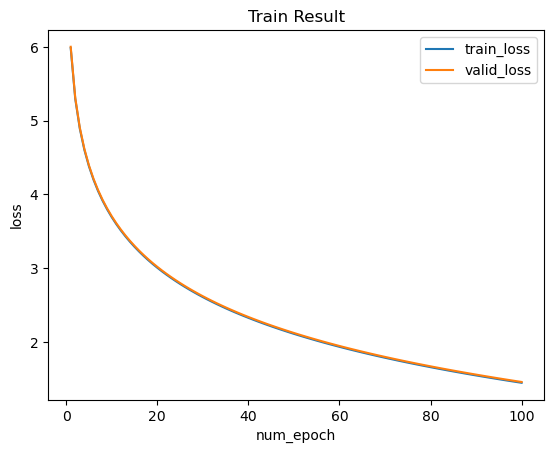

In [14]:
k, num_epochs, learning_rate, weight_decay, batch_size = 7, 100, 0.5, 0, 64
train_loss, valid_loss = K_fold(k, train_features, train_labels, num_epochs, batch_size, learning_rate, weight_decay)
print(f'{k}-折验证: 平均训练log rmse: {float(train_loss):f}, '
      f'平均验证log rmse: {float(valid_loss):f}')

In [15]:
pred = net(test_features)
res = pd.DataFrame({'Id':list(range(1461,1461+1459)), 'SalePrice': pred.detach().numpy().flatten()})
#res['Id'] = res['Id'].apply(lambda x: f"'{x}'")
res.to_csv("result.csv", index=False)